# Production of Fuelimycin A in _Chlamydomonas Reinhardtii_

## 1. Introduction

### Literature review of the compound

#### Applications of the product
When trying to slow down climate change, reducing the use of petroleum is key. While biodiesel and bioethanol as well as electrification of vehicles are successful replacements for some fossil fuels, energy-demanding applications like rocketry, aviation, and shipping are fueled with petroleum-derived hydrocarbons that are difficult to replace. These fuels are often rich in cyclic and branched alkanes which makes them very energy-dense but also hard to synthesize by organic chemistry (Holladay et al., 2022). In 2022, Cruz-Mortales et al. described the successful production of polycyclopropanated fatty acid methyl esters (POP-FAME) in bacteria and showed that these molecules, named fuelimycin, are suitable to replace fossil rocket and jet fuel. 

#### Evaluation of market potential 

Due to the complicated structure of these molecules, their organic synthesis from fossil fuel is costly, challenging, involves toxic substances and is therefore economically not feasible [(Pietruszka, 2003)](https://doi.org/10.1021/cr010027g). This makes the biotechnological production of POP compounds not only more sustainable and independent from fossil resources but might also present a more effective synthesis process of fuels with superior properties [(Baral, Kavvada, et al., 2019)](https://doi.org/10.1021/acssuschemeng.9b01229). The market for these fuels is large and promising, considering that jet fuel has a current market value of $ 190 billion, and are expected to double over the next 20 years (Holladay et al., 2022; [Prakhar & Yerukola, 2022](https://www.alliedmarketresearch.com/jet-fuel-market-A06883)). A general market advantage of the biotechnological route to produce crude oil-based compounds is that they are independent of changes in price and availability of fossil fuels. This, in turn, allows for a constant price and supply of the product which is beneficial for both producer and consumer.  

#### Biosynthetic pathway/gene 

For the biotechnological production of the POP-FAMEs in Streptomyces, Cruz-Mortales et al. explored the chemical diversity of naturally occurring cyclopropanated molecules and found two candidates in Streptomyces. The minimal set of genes involved in the biosynthetic pathway of POP-FAs are present in a biosynthetic gene cluster (BGC) of 4 genes, pop 1-4. They encode an iterative polyketide synthase (iPKS), including ketosynthase, acyltransferase, dehydratase, and ACP (KS-AT-DH-ACP) domains (pop 1), a SAM-dependent cyclopropanase (pop 2), a ketoreductase (pop 3) and a thioesterase (pop4) as shown in figure 1. These genes are sufficient for the formation of fuelimycins in a heterologous host. 

<div>
<img src="Images/pathway.jpeg" width="700"/>
</div>

### Literature review of the cell factory

#### General advantages  

Microalgae are photosynthetic microorganisms, capable of fixing light to produce biomass and are more efficient in doing so than land plants. Recently they have received increased intention as biotechnological production hosts due to the high amounts of protein, starch, and lipid many species can produce without requiring high quality agricultural land [(Hann et al., 2022)](https://doi.org/10.1038/s43016-022-00530-x). _Chlamydomonas reinhardtii_ is a single cell green alga and one of the best studied microalgae. It can easily be cultivated, grows fast and tools for genetic engineering are available which contributed to making it a popular production platform for hydrogen, biopharmaceuticals, and biofuels [(Schroda & Remacle, 2022)](https://doi.org/10.3389/fpls.2022.911483). _C. reinhardtii_ is photoautotrophic but can also grow on organic carbon sources when cultivated in the dark [(Hann et al., 2022)](https://doi.org/10.1038/s43016-022-00530-x).  

#### General disadvantages  

Even though the cultivation of microalga is fast and easy compared to land plants, it remains slower and more difficult than cultivation of bacterial production hosts or yeast. Furthermore, the use of microalgae is severely limited by the light permeability within the special photobioreactors if grown phototrophically which becomes the main limiting factor at high cell-densities, worsened by the intrinsic inefficiency of the photosynthetic apparatus. The upscaling of production processes with microalgae is therefore very difficult and often not feasible. To produce biofuels in particular, the downstream processing can cause complications [(Banerjee et al., 2016)](https://doi.org/10.3389/fmicb.2016.00432). When grown on organic carbon, they face the same problems as other heterotrophically grown organisms, especially the requirement of expensive feedstock that competes with food production for land and water.  

#### Cell Factory Choice  

Nonetheless, microalgae can be valuable organisms for production of many value-added compounds such as terpenoids and biofuel precursors due to the high lipid content species such as _C. reinhardtii_ are able to generate which is considerably more than typical oilseed crops can make [(Pienkos & Darzins, 2009)](https://doi.org/10.1002/bbb.159). Microalgae can have an oil content of more than 50%, stored in lipid bodies. _C. reinhardtii_ therefore seems the perfect choice for an alternative host to produce POP-FAMES as described by Cruz-Morales et al. As shown by Hann et al., electrochemically produced acetate can serve as carbon source for many organisms, including _C. reinhardtii_ where it can act as only carbon-source, enabling growth without the need of visible light. Acetate is a soluble, two-carbon substrate that can electrochemically be produced from CO2, which makes it an environmentally very sustainable feedstock.  

#### What would be suitable alternative cell factories and why is the selected one more interesting? 

Cruz-Morales et al. used _Streptomyces coelicolor_ as host which allowed for production using naturally occurring processes in the host. While this cell factory is the first one in which fuelimycin production has been reported, it requires a sugar feed which is expensive, increasing the overall cost of production. The team therefore chose to use _C. reinhardtii_ because of the ability to use cheap and sustainable acetate as growth medium while also being known to be a suitable host for high-energy lipids. 

## 2. Problem definition

The process described by Cruz-Morales et al. is ground-breaking but requires high yields. To be competitive with conventional fuels, the required titre, rate, and yield depend on target market and feedstock costs but selling prices of around $3 per gallon should be achieved. In the previous host organism, approximately 0.29 g of product per gram of sugar, and yields of almost 90% are needed to achieve this price goal ([Baral, Sundstrom, et al., 2019](https://doi.org/10.1021/acssuschemeng.9b01229); [Blanch, 2012](https://doi.org/https://doi.org/10.1016/j.copbio.2011.10.002)). By optimizing the process to work on a cheaper medium the yield requirement can be lowered to more achievable levels.  By substituting the sugar feed for acetate, the constraint of feed price is greatly reduced allowing for an edge. Since the new host, _C. reinhardtii_, will be grown heterotrophically on acetate there are no reactor constraints regarding light supply. Assuming that the acetate is obtained from electrochemical conversion, this process is not only cheaper but also more sustainable compared to a process based on sugar feed. Additionally, we hope that the translation of the process to the new host results in the same or even higher concentration of fuelimycins based on the excellence performance of _C. reinhardtii_ in the production of other high-energy lipids [(Wang et al., 2009)](https://doi.org/10.1128/EC.00272-09). 

## 3. Selection and assessment of existing GSM

We decided to choose the iCre1355 model for _Chlamydomonas reinhardtii_. We assessed it by uploading it to Memote [(Lieven et al.)](https://www.nature.com/articles/s41587-020-0446-y), where the model obtained an overall score of 25%. There were other models available for our host (e.g. iRC1080). Even though the overall score of memote for iCre1355 is 25% and for iRC1080 is 75%, the Consistency field is better for the first model. Specifically, the mass balance and the unbounded flux in default medium are the subfields with more improvement, with scores of 97.8% and 92.1% respectively for iCre1355 and 68.7% and 70.2% respectively for iRC1080. Therefore, the difference between the scores is due to the annotation of metabolites and reactions, which is present for iRC1080 but it is absent for iCre1355. However, we decided to choose the iCre1355 mainly because all genes have been manually curated and assigned their known or most likely biological function [(Imam et al.)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4715634/). In addition, we chose this model because the benchmark against iRC1080 shows that its predictive accuracy is higher and thus it has a greater potential value as a tool for generating hypothesis to guide future experimental design. 

We expect the GSM model iCre1355 to facilitate reliable predictions based on its publication and experimental validation as explained above. Furthermore, work performed by Saheed Imam et al. shows that metabolic responses of _C. reinhardtii_ at the systems-level can be seen due to changes in the environmental conditions with the iCre1355 model. All in all, the iCre1355 model provides a better framework to analyze microalgae metabolism. 

As explained before, even if the overall score of memote is lower for iCre1355 than for iRC1080, we expect reliable predictions based on the Consistency scores of the model we chose. Nonetheless, when proposing gene knockout strategies, genes need to be properly annotated after the analysis in order to allow for laboratory testing. 

## 4. Computer-aided cell factory engineering

### Import libraries

In [22]:
import os
from cobra.io import read_sbml_model, write_sbml_model
from cobra.util import create_stoichiometric_matrix
import numpy as np
from pandas import DataFrame
from cobra import Reaction, Metabolite
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
import matplotlib.pyplot as plt
%matplotlib inline

### Load the model

In [23]:
script_path = os.getcwd()
path_model = 'Models/iCre1355_auto_fbc.xml'
path_model2 = 'Models/iRC1080.xml'
model = read_sbml_model(os.path.join(script_path, path_model))
model2 = read_sbml_model(os.path.join(script_path, path_model2))

No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


### Memote assessment

First, we assessed both available models with memote to compare their quality.

In [51]:
# Model 1
#!memote report snapshot --filename "Memote/iCre1355_auto_fbc.html" path_model

In [52]:
# Model 2
#!memote report snapshot --filename "iRC1080.html" path_model2

### Explore the model & create S matrix

In [26]:
# Explore the model
print("The model has %d reactions, %d metabolites and %d genes" % (len(model.reactions), len(model.metabolites), len(model.genes)))

The model has 2394 reactions, 1845 metabolites and 1963 genes


In [27]:
# Create the stoichiometric matrix
S = create_stoichiometric_matrix(model)
print(S)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
# Check non-zero elements of S
non_zero_elem = np.count_nonzero(S)
zero_elem = np.count_nonzero(S==0)
print("The percentage of non-zero elements in S is:", str(non_zero_elem/(zero_elem + non_zero_elem)*100) + "%")

The percentage of non-zero elements in S is: 0.2494492781185122%


### Check autotroph growth rate on initial conditions

In [29]:
# Check initial media composition
model.medium

{'EX_h_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 1.0,
 'EX_so4_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_photonVis_e': 80.0,
 'EX_o2_e': 10.0,
 'EX_co2_e': 2.0}

In [30]:
# Add objective function
model.objective = 'Biomass_Chlamy_auto'

In [31]:
# Simulate the model
solution = model.optimize()
solution

,fluxes,reduced_costs
AAT,0.000011,0.000000e+00
ALATLm,0.000000,0.000000e+00
ASNTLm,0.000000,0.000000e+00
ASPO,0.000000,-1.110223e-16
ASPOm,0.000000,-1.110223e-16
...,...,...
PYDXPP,0.000000,0.000000e+00
PYDXS,0.000000,0.000000e+00
Biomass_Chlamy_auto,0.051575,-2.657596e-15
Biomass_Chlamy_mixo,0.000000,-2.020611e+00


We can confirm that with the initial medium composition, the organism can grow with a **0.052 $gDW/mmol$ (growth rate).**

### Add acetate to the medium

In [32]:
# Change medium composition (add 17.5 mM of acetate)
medium = model.medium
medium['EX_ac_e'] = 17.5
model.medium = medium
model.medium

{'EX_h_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 1.0,
 'EX_so4_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_photonVis_e': 80.0,
 'EX_o2_e': 10.0,
 'EX_co2_e': 2.0,
 'EX_ac_e': 17.5}

### Add heterologous metabolites and reactions

We will add 2 reactions: the fuelimycin A production and the fuelimycin A exchange.

In [33]:
### Create metabolite ###
metabolite1 = Metabolite('fuelimycinA_c')
metabolite1.name = 'Fuelimycin A'
metabolite1.formula = 'C29H38O2'
metabolite1.compartment = 'c'
model.add_metabolites([metabolite1])

### Define production of jet fuel reaction ###
reaction1 = Reaction('fuelimycinA')
reaction1.name = 'iPKS'
reaction1.lower_bound = 0.  # This makes the reaction irreversible
reaction1.upper_bound = 1000.  # This is the default ub

# Add metabolites to the reaction
reaction1.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -11.0,
    model.metabolites.get_by_id("nadp_c"): 11.0,
    model.metabolites.get_by_id("amet_c"): -7.0,
    model.metabolites.get_by_id("ahcys_c"): 7.0,
    model.metabolites.get_by_id("nadph_c"): -11.0,
    model.metabolites.get_by_id("h_c"): 11.0,
    model.metabolites.get_by_id("fuelimycinA_c"): 1.0
})

### Define jet fuel exchange reaction ###
reaction2 = Reaction('EX_fuelimycinA')
reaction2.name = 'Fuelimycin A exchange'
reaction2.lower_bound = 0.  # This makes the reaction irreversible
reaction2.upper_bound = 1000.  # This is the default ub

# Add metabolites to the reaction
reaction2.add_metabolites({
    model.metabolites.get_by_id("fuelimycinA_c"): -1.0
})

# Add reactions to the model
model.add_reactions([reaction1, reaction2])

# Print reactions
print(reaction1.reaction)
print(reaction2.reaction)

11.0 ac_c + 7.0 amet_c + 11.0 nadph_c --> 7.0 ahcys_c + fuelimycinA_c + 11.0 h_c + 11.0 nadp_c
fuelimycinA_c --> 


In order to simulate a realistic scenario, we need to fix the biomass reaction upper and lower boundaries so that the organism grows despite optimizing for the production of fuelimycin A. We decided to keep the optimal growth rate at **0.052** in this case, because lowering it did not make a huge impact in the fuelimycin production.

In [34]:
# Adjust lb and up of biomass_auto so that model grows
model.reactions.get_by_id("Biomass_Chlamy_auto").lower_bound = 0.052
model.reactions.get_by_id("Biomass_Chlamy_auto").upper_bound = 0.052

### Change objective function and calculate maximum theoretical yield

In [36]:
# Change objective function
model.objective = 'fuelimycinA'

In [37]:
# Simulate the model and get max theoretical yield of fuelimycin A
solution = model.optimize()
solution

,fluxes,reduced_costs
AAT,0.000011,0.000000e+00
ALATLm,0.000000,4.336809e-18
ASNTLm,0.000000,-1.387779e-17
ASPO,0.000000,-1.618123e-02
ASPOm,0.000000,-1.618123e-02
...,...,...
Biomass_Chlamy_auto,0.052000,-2.900226e+00
Biomass_Chlamy_mixo,0.000000,-2.948990e+00
Biomass_Chlamy_hetero,0.000000,-1.774323e+00
fuelimycinA,1.055922,-9.922618e-16


As it can be seen in the solution table, the **maximal theoretical yield of fualimycin A is 1.056 $mmol·gDW^{-1}·h^{-1}$**

### Phenotypic phase planes

In [38]:
# Phenotypic phase plane (ppp) of acetate
ppp_ac = production_envelope(model,
                    reactions=[model.reactions.EX_ac_e],
                    objective=model.reactions.fuelimycinA)
ppp_ac

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_ac_e
0,EX_ac_e,0.0,0.0,NaN,1.055922,10.800574,NaN,-17.500000
1,EX_ac_e,0.0,0.0,NaN,1.011977,10.925848,NaN,-16.579388
2,EX_ac_e,0.0,0.0,NaN,0.967986,11.065332,NaN,-15.658775
3,EX_ac_e,0.0,0.0,NaN,0.923466,11.215811,NaN,-14.738163
4,EX_ac_e,0.0,0.0,NaN,0.878946,11.386342,NaN,-13.817551
5,EX_ac_e,0.0,0.0,NaN,0.834426,11.581218,NaN,-12.896938
6,EX_ac_e,0.0,0.0,NaN,0.789906,11.806054,NaN,-11.976326
7,EX_ac_e,0.0,0.0,NaN,0.745386,12.068334,NaN,-11.055714
8,EX_ac_e,0.0,0.0,NaN,0.698396,12.334638,NaN,-10.135101
9,EX_ac_e,0.0,0.0,NaN,0.634905,12.333620,NaN,-9.214489


/var/folders/5p/3vntk1ms267_zxphn5yv54mm0000gn/T/ipykernel_62638/2244642164.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


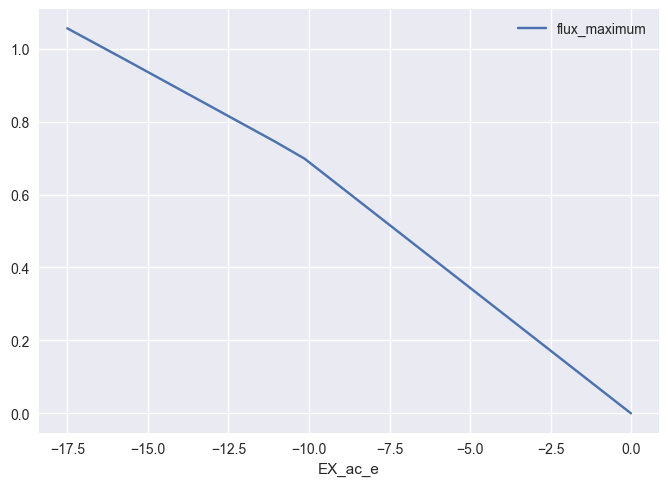

In [39]:
plt.style.use('seaborn')
ppp_ac.plot(x='EX_ac_e', y='flux_maximum');

As expected, the flux of Fuelimycin A decreases if the amount of acetate in the media is lower.

In [40]:
# Phenotypic phase plane (ppp) of acetate (aerobic vs anaerobic)
ppp_ac_3D = production_envelope(model, reactions=[model.reactions.EX_ac_e, model.reactions.EX_o2_e],
                                   objective=model.reactions.fuelimycinA, points=50)
ppp_ac_3D

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_ac_e,EX_o2_e
0,EX_ac_e,0.0,0.0,NaN,1.025761,10.492071,NaN,-17.500000,-10.000000
1,EX_ac_e,0.0,0.0,NaN,1.027320,10.508020,NaN,-17.500000,-9.796903
2,EX_ac_e,0.0,0.0,NaN,1.028880,10.523970,NaN,-17.500000,-9.593806
3,EX_ac_e,0.0,0.0,NaN,1.030435,10.539877,NaN,-17.500000,-9.390709
4,EX_ac_e,0.0,0.0,NaN,1.031972,10.555598,NaN,-17.500000,-9.187612
...,...,...,...,...,...,...,...,...,...
2495,EX_ac_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.008366,-0.860634
2496,EX_ac_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.008366,-0.657537
2497,EX_ac_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.008366,-0.454440
2498,EX_ac_e,NaN,NaN,NaN,NaN,NaN,NaN,-0.008366,-0.251343


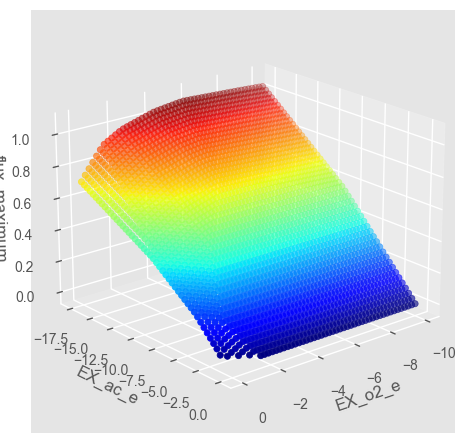

In [50]:
#ppp_ac_3D.plot(x='EX_o2_e', y='EX_ac_e', z='flux_maximum')

ax = plt.axes(projection='3d')
ax.scatter3D(ppp_ac_3D['EX_o2_e'], ppp_ac_3D['EX_ac_e'], ppp_ac_3D['flux_maximum'], 
             c=ppp_ac_3D['flux_maximum'], cmap='jet')

ax.view_init(20, 50, 0)
ax.set_xlabel('EX_o2_e')
ax.set_ylabel('EX_ac_e')
ax.set_zlabel('flux_maximum');

As the concentration of acetate decreases in the medium, the flux maximum (z axis) of fuelimycin A is reduced (as expected). The same happens when the oxygen levels are lowered. However, the organism is capable of maintaining the maximum fuelimycin A yield until the oxygen is roughly half of the initial conditions.

### Check essential genes for fuelimycin A production

In [42]:
# See what genes are essential in our model
plt.style.use('ggplot')
essentiality = set()
opt_value = model.slim_optimize()
for gene in model.genes:
    with model:
        gene.knock_out()
        new_value = model.slim_optimize(error_value=0.)
        if new_value < opt_value - 0.1:
            essentiality.add(gene.id)

In [43]:
print("There are", len(essentiality), "essential genes for fuelimycin A production.")

There are 289 essential genes for fuelimycin A production.


In [48]:
essential_reactions = set()
for gene in essentiality:
    for rxn in model.genes.get_by_id(gene).reactions:
        essential_reactions.add(rxn.id)
print("There are", len(essential_reactions), "essential reactions for fuelimycin A production.")

There are 556 essential reactions for fuelimycin A production.


## 5. Discussion

In order to have a growth rate > 0 in our model, we had to include light in form of photons in the conditions. Without photons, the model objective for biomass always yields 0. This is likely due to the model we used in which the possibility of _C. reinhardtii_ to grow heterotrophically without light is not considered. However, since it has been shown several times that _C. reinhardtii_ is able to grow on carbon sources in the dark, we were confident to ignore this mistake in the model. According to [Hann et al.](https://www.nature.com/articles/s43016-022-00530-x) growth of C. reinhardtii in acetate without light should be equivalent or even higher than the control, so it is reasonable assumptiont that keeping light does not greatly effect results. When further investigating this organism for fuelimycin production, one should modify the model to include the possibility of heterotrophic growth on acetate. 

As described, integration of a heterologous gene cluster of only 4 genes is needed to enable fuelimycin formation. To further increase the titre and yield, Cruz-Morales introduced several additional modifications that were known from literature. These included the integration of an additional copy of MetK, a SAM synthetase to increase the precursor supply, of two phosphopantetheinyltransferases (PPTase) for PKS maturation, disruption of pirA involved in oxidative stress and overexpression of pop4 (thioesterase) to increase the concentration of this enzyme compared to pop1-3, resulting in higher processivity of the pathway (Cruz-Morales et al., 2022). These modifications resulted in a 22 higher titre compared to the initial strain. In a next step, the implementation of these or similar modifications to the GSM of _C. reinhardtii_ should therefore be considered.

After optimising the computational model, it should be validated experimentally. Considering the multiple tools available for _C. reinhardtii_ that allow for simple genetic engineering such as a CRISPR-Cas9 system, suitable integration sites or multiple promoters, this step is feasible and can be performed within relatively short time (Schroda & Remacle, 2022). Afterwards, additional engineering in vivo will likely have to be performed to further optimise the strain. Despite the high accuracy of the chosen model according to memote, in-silico predictions cannot (yet) completely mimic the actual behaviour of a strain.  

## 6. Conclusion

In order to tackle the problem of fuel production, we used a GSM model to propose an optimization solution for the production of a novel class of high-energy chemicals (POP-FAMEs, represented by fuelimycin A) with the potential to be used as jet fuel. The chosen host is the model organism _C. reinhardtii_, one of the most caracterized photosynthetic organisms, hence with multiple available GSMs, and a natural producer of lipophile substances such as fatty acids and terpenoids. The chosen model (iCre1355) shows an overall low score in memote but the highest consitency on the metabolic level, which we regard as useful to guide future metabolic engineering strategies. 

The main limitation of this host is its native dependency on the photosynthetic apparatus, which represents the main bottleneck for instrial applicability of all photosynthetic organisms due to its intrinsic inefficiency when compared to energy-harvesting technologies, such as photovoltaic and other renewable sources. Following [Hann _et al._](https://www.nature.com/articles/s43016-022-00530-x) demonstration on the use of electrochemically-produced, acetate-rich effluxes as only carbon source for various organisms, such as _C. reinhardtii_, we propose the use of acetate as carbon source for the production of fuelimycin A, thereby making the production carbon-negative on the environmental footprint point of view. 

To design the production strain, we successfully introduced the reaction pathway into our model, and found a compromise between maximum production of fuelimycin A and growth rate. Lastly, we determined gene and reaction essentialities in order to guide future knockout strategies for strain production. With the research provided by [Hann _et al._](https://www.nature.com/articles/s43016-022-00530-x), and the provided data from this project the novel process is ready to be implemented and tested in the lab. 

## 7. References

Banerjee, C., Dubey, K. K., & Shukla, P. (2016). Metabolic engineering of microalgal based biofuel production: Prospects and challenges. In Frontiers in Microbiology (Vol. 7, Issue MAR). Frontiers Media S.A. https://doi.org/10.3389/fmicb.2016.00432 

Baral, N. R., Kavvada, O., Mendez-Perez, D., Mukhopadhyay, A., Lee, T. S., Simmons, B. A., & Scown, C. D. (2019). Techno-economic analysis and life-cycle greenhouse gas mitigation cost of five routes to bio-jet fuel blendstocks. Energy & Environmental Science, 12(3), 807–824. https://doi.org/10.1039/C8EE03266A 

Baral, N. R., Sundstrom, E. R., Das, L., Gladden, J., Eudes, A., Mortimer, J. C., Singer, S. W., Mukhopadhyay, A., & Scown, C. D. (2019). Approaches for More Efficient Biological Conversion of Lignocellulosic Feedstocks to Biofuels and Bioproducts. ACS Sustainable Chemistry & Engineering, 7(10), 9062–9079. https://doi.org/10.1021/acssuschemeng.9b01229 

Blanch, H. W. (2012). Bioprocessing for biofuels. Current Opinion in Biotechnology, 23(3), 390–395. https://doi.org/https://doi.org/10.1016/j.copbio.2011.10.002 

Cruz-Morales, P., Yin, K., Landera, A., Cort, J. R., Young, R. P., Kyle, J. E., Bertrand, R., Iavarone, A. T., Acharya, S., Cowan, A., Chen, Y., Gin, J. W., Scown, C. D., Petzold, C. J., Araujo-Barcelos, C., Sundstrom, E., George, A., Liu, Y., Klass, S., … Keasling, J. D. (2022). Biosynthesis of polycyclopropanated high energy biofuels. Joule, 6(7), 1590–1605. https://doi.org/10.1016/j.joule.2022.05.011 

Hann, E. C., Overa, S., Harland-Dunaway, M., Narvaez, A. F., Le, D. N., Orozco-Cárdenas, M. L., Jiao, F., & Jinkerson, R. E. (2022). A hybrid inorganic–biological artificial photosynthesis system for energy-efficient food production. Nature Food, 3(6), 461–471. https://doi.org/10.1038/s43016-022-00530-x 

Holladay, J., Abdullah, Z., & Heyne, J. (2022). Sustainable aviation fuel: review of technical pathways report (Office of Energy Efficiency and Renewable Energy). 

Imam, S. et al. (2015) “A refined genome‐scale reconstruction of chlamydomonas metabolism provides a platform for systems‐level analyses,” The Plant Journal, 84(6), pp. 1239–1256. Available at: https://doi.org/10.1111/tpj.13059.

Pienkos, P. T., & Darzins, A. (2009). The promise and challenges of microalgal-derived biofuels. Biofuels, Bioproducts and Biorefining, 3(4), 431–440. https://doi.org/10.1002/bbb.159 

Pietruszka, J. (2003). Synthesis and Properties of Oligocyclopropyl-Containing Natural Products and Model Compounds. Chemical Reviews, 103(4), 1051–1070. https://doi.org/10.1021/cr010027g 

Prakhar, J., & Yerukola, P. (2022). Jet Fuel Market. Global Oppurtunity Analysis and Industry Forecast, 2021-2030. https://www.alliedmarketresearch.com/jet-fuel-market-A06883 

Schroda, M., & Remacle, C. (2022). Molecular Advancements Establishing Chlamydomonas as a Host for Biotechnological Exploitation. In Frontiers in Plant Science (Vol. 13). Frontiers Media S.A. https://doi.org/10.3389/fpls.2022.911483 

Wang, Z. T., Ullrich, N., Joo, S., Waffenschmidt, S., & Goodenough, U. (2009). Algal lipid bodies: Stress induction, purification, and biochemical characterization in wild-type and starchless chlamydomonas reinhardtit. Eukaryotic Cell, 8(12), 1856–1868. https://doi.org/10.1128/EC.00272-09 

# TO DO

1. Change in-text references so that they all have the same format and the link to the corresponding paper.
2. Add the references to the end of the document (point 7).
3. Check Discussion and Conclusion (e.g. we need to change the numbers in the conclusion, probably there are things to change in the Discussion as well).
4. Add the discussion of why we chose to keep light in the model but we know from research that this organism can grow without light in Discussion.
5. Change the 3D plot to an actual 3D plot.
6. Check if units of fuelimycin A production are correct.